# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет.
Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Изучение общей информации

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
data = pd.read_csv('real_estate_data.csv', sep='\t')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [3]:
with pd.option_context("display.max_columns", None):
    display(data)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.81,2017-03-21T00:00:00,3,3.70,5.0,73.3,3,NaN,False,False,13.83,NaN,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,NaN,5.0,38.0,4,NaN,False,False,8.50,NaN,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,NaN,3.0,29.7,1,NaN,False,False,NaN,NaN,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23697,13,11475000.0,76.75,2017-03-28T00:00:00,2,3.00,17.0,NaN,12,NaN,False,False,23.30,2.0,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0


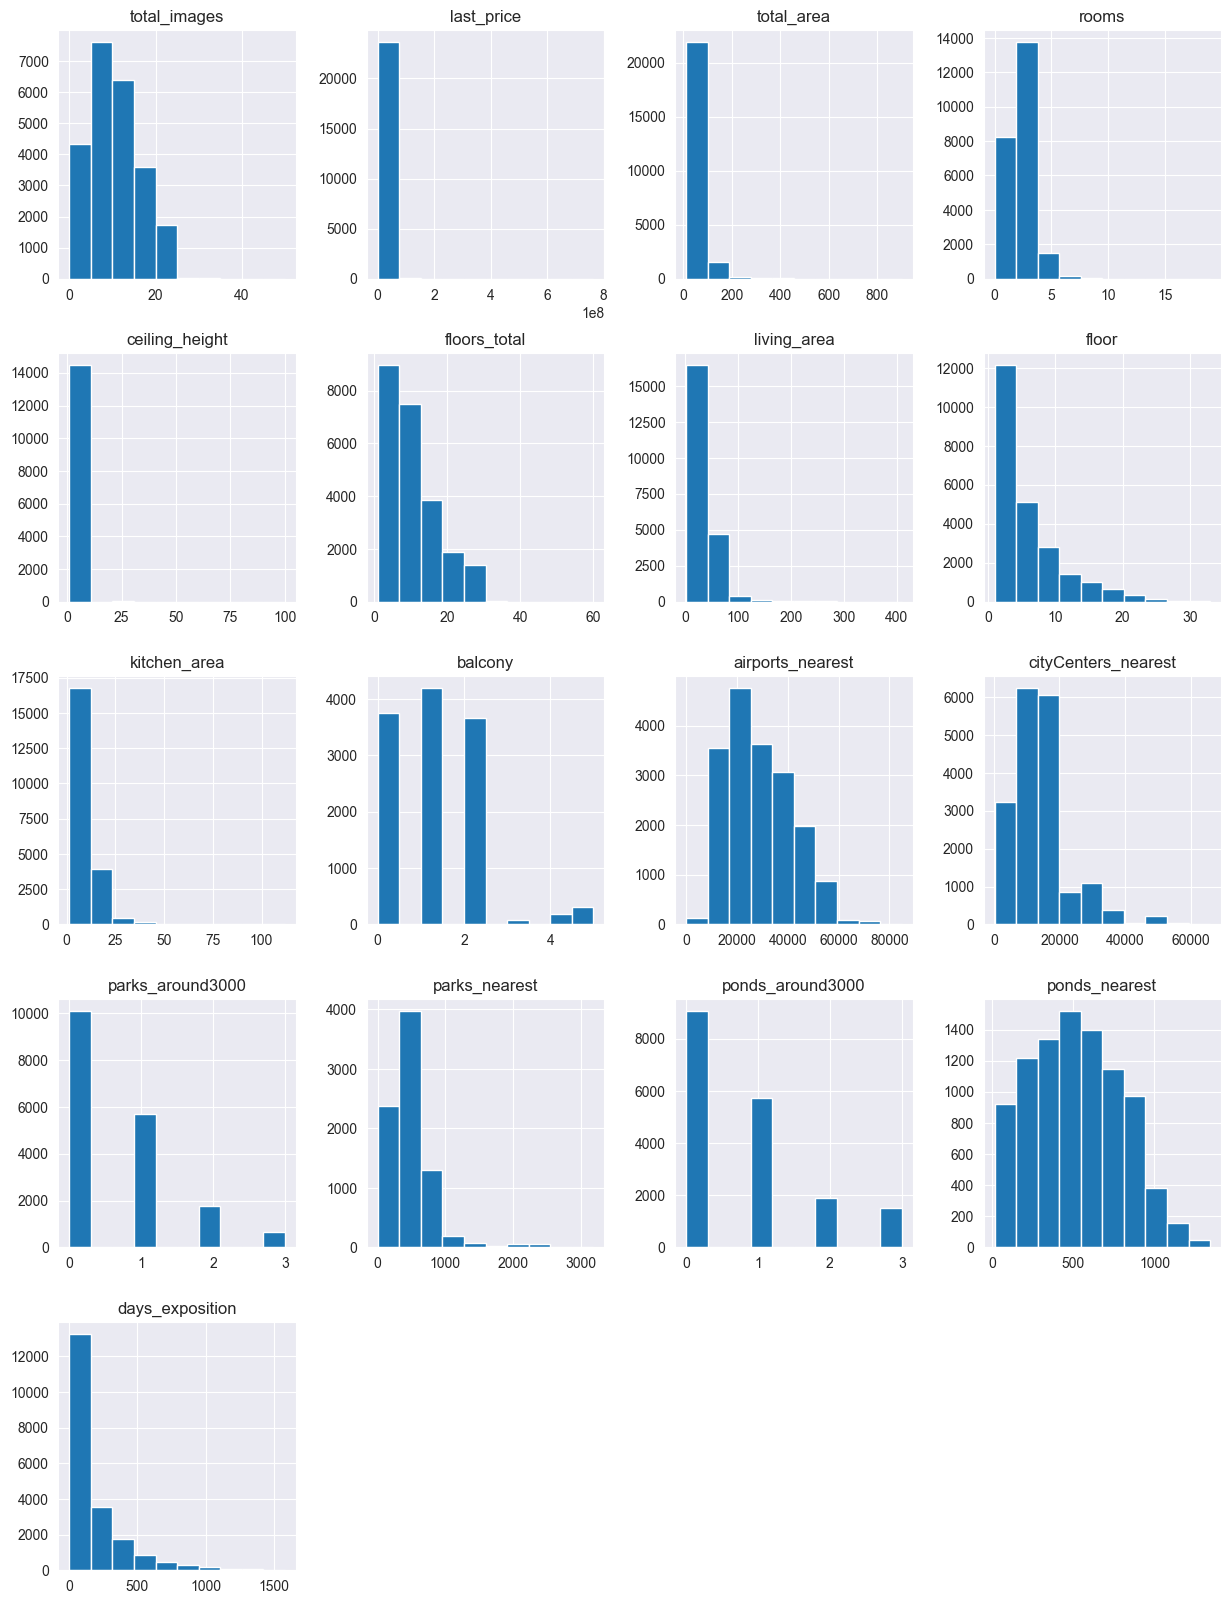

In [4]:
data.hist(figsize=(15, 20));

Рассматривая таблицу `info`, можно увидеть, что в 14 из 22 столбцов имеются пропуски. Также в части столбцов используется неправильный тип данных. На некоторых графиках можно заметить, что горизонтальная ось слишком вытянута относительно ширины столбцов гистограммы, что говорит об аномальных значениях. Все эти возможные проблемы будут проверяться и решаться в последующих пунктах этой работы.

### Предобработка данных

#### Поиск и устранение пропусков

In [5]:
# Поиск столбцов с пропусками данных

data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Сначала пройдёмся по столбцам с пропусками, которые скорее всего можно заполнить чем-то без потери объективности данных.

In [6]:
# Проверка максимального этажа

data[pd.isna(data['floors_total']) == True]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
186,12,11640000.0,65.2,2018-10-02T00:00:00,2,NaN,NaN,30.80,4,NaN,...,12.00,NaN,Санкт-Петербург,39197.0,12373.0,1.0,123.0,0.0,NaN,49.0
237,4,2438033.0,28.1,2016-11-23T00:00:00,1,NaN,NaN,20.75,1,NaN,...,NaN,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,251.0
457,4,9788348.0,70.8,2015-08-01T00:00:00,2,NaN,NaN,38.40,12,NaN,...,10.63,0.0,Санкт-Петербург,37364.0,8322.0,2.0,309.0,2.0,706.0,727.0
671,4,6051191.0,93.6,2017-04-06T00:00:00,3,NaN,NaN,47.10,8,NaN,...,16.80,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,123.0
1757,5,3600000.0,39.0,2017-04-22T00:00:00,1,NaN,NaN,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,22735.0,11618.0,1.0,835.0,1.0,652.0,77.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22542,5,8500000.0,63.5,2017-05-24T00:00:00,2,2.8,NaN,NaN,3,NaN,...,NaN,NaN,Санкт-Петербург,51340.0,15363.0,0.0,NaN,1.0,853.0,512.0
22656,4,4574160.0,64.5,2017-04-02T00:00:00,2,NaN,NaN,31.70,20,NaN,...,14.40,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,127.0
22808,0,14569263.0,110.4,2016-11-20T00:00:00,3,NaN,NaN,45.38,6,NaN,...,23.42,0.0,Санкт-Петербург,19095.0,4529.0,0.0,NaN,0.0,NaN,260.0
23590,0,21187872.0,123.3,2017-04-25T00:00:00,3,NaN,NaN,50.40,18,NaN,...,23.60,0.0,Санкт-Петербург,19095.0,4529.0,0.0,NaN,0.0,NaN,104.0


Если при пропуске значений столбца `floors_total` значения столбца `floor` всегда были бы равны 1, то можно было предположить, что и `floors_total` равен 1, но таблица доказывает обратное, так что значение останется пустым.

In [7]:
# Замена пустых значений жилой площади, путём нахождения соотношения средней жилой площади к средней общей площади

liv_total_area_ratio = data['living_area'].mean() / data['total_area'].mean()
data['living_area'] = data['living_area'].fillna(data['total_area'] * liv_total_area_ratio)
data['living_area'].isna().sum()

0

При помощи создания коэффициента соотношения средней жилой площади к средней общей площади `liv_total_area_ratio`, можно восполнить пропуски в данных. Да, эти данные будут не самые точные, но статистически обоснованные.

In [8]:
# Замена пустых значений площади кухни, путём нахождения соотношения средней площади кухни к средней жилой площади

kitchen_liv_area_ratio = data['kitchen_area'].mean() / data['living_area'].mean()
data['kitchen_area'] = data['kitchen_area'].fillna(data['living_area'] * kitchen_liv_area_ratio)
data['kitchen_area'].isna().sum()

0

Аналогично предыдущему пункту.

In [9]:
# Замена пустых значений количества балконов на 0

data['balcony'] = data['balcony'].fillna(0)
data['balcony'].isna().sum()

0

Смеем предположить, что пользователь не указал количество балконов из-за того, что они просто-напросто отсутствуют, так что было принято решение заполнить все пропуски значением `0`.


In [10]:
# Замена пустых значений вида апартаментов 

data['is_apartment'] = data['is_apartment'].fillna(False)
data['is_apartment'].isna().sum()

0

Скорее всего пользователь не указал, относится ли недвижимость к апартаментам, так как она ими не является, так что пустые ячейки были заполнены как `False`.

In [11]:
# Проверка картографических данных

data.query('(parks_around3000.isna()) & (parks_nearest.isna()) & (ponds_around3000.isna()) & (ponds_nearest.isna()) & (cityCenters_nearest.isna()) & (airports_nearest.isna())')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.400000,5,False,...,9.100000,0.0,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.430000,26,False,...,8.810000,0.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
12,10,3890000.0,54.00,2016-06-30T00:00:00,2,NaN,5.0,30.000000,5,False,...,9.000000,0.0,Сертолово,NaN,NaN,NaN,NaN,NaN,NaN,90.0
22,20,5000000.0,58.00,2017-04-24T00:00:00,2,2.75,25.0,30.000000,15,False,...,11.000000,2.0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,60.0
30,12,2200000.0,32.80,2018-02-19T00:00:00,1,NaN,9.0,18.728133,2,False,...,5.722158,0.0,Коммунар,NaN,NaN,NaN,NaN,NaN,NaN,63.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23683,16,2100000.0,62.80,2018-09-18T00:00:00,4,2.50,5.0,45.500000,3,False,...,5.500000,0.0,посёлок Дзержинского,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23692,2,1350000.0,30.00,2017-07-07T00:00:00,1,NaN,5.0,17.500000,4,False,...,6.000000,0.0,Тихвин,NaN,NaN,NaN,NaN,NaN,NaN,413.0
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,NaN,5.0,38.000000,4,False,...,8.500000,0.0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,NaN,3.0,29.700000,1,False,...,9.074481,0.0,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Как можно заметить из таблицы выше, 5518 значений не имеют точной географической привязки, поэтому заполнение пропусков здесь невозможно. 

Причиной отсутствия географической привязки скорее всего является указание неполного адреса недвижимости (например, указание только улицы или только наименования населённого пункта).

Пропуски в `airports_nearest`, `cityCenters_nearest`, `parks_nearest`, `ponds_nearest` являются логичными, так как этих объектов просто-напросто нет рядом с недвижимостью, либо пользователь этого не указал.

Остальные столбы имеют пропуски, которые невозможно заполнить, поэтому мы их оставим пустыми.    

In [12]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

#### Преобразование типов данных

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           23699 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  bool   
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          23699 non-null  float64
 13  balcony               23699 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Глядя на данные из таблицы выше, можно предположить, что не всем столбцам подходят их типы данных.  
Займёмся проверкой и исправлением этого.


In [14]:
# Преобразование даты

data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d')
data['first_day_exposition']



0       2019-03-07
1       2018-12-04
2       2015-08-20
3       2015-07-24
4       2018-06-19
           ...    
23694   2017-03-21
23695   2018-01-15
23696   2018-02-11
23697   2017-03-28
23698   2017-07-21
Name: first_day_exposition, Length: 23699, dtype: datetime64[ns]

На случай, если с данными столбца `first_day_exposition` будут производиться какие-либо вычисления, было принято решение преобразовать тип данных object в datetime, так как значения в столбце являются датой.

In [15]:
# Количество дней размещения объявления

data['days_exposition'] = data['days_exposition'].round(0).astype('Int64')
data['days_exposition']

0        <NA>
1          81
2         558
3         424
4         121
         ... 
23694    <NA>
23695      45
23696    <NA>
23697     602
23698    <NA>
Name: days_exposition, Length: 23699, dtype: Int64

Дни не принято записывать вещественными числами.

In [16]:
# Количество этажей

data['floors_total'] = data['floors_total'].astype('Int64')
data['floors_total']

0        16
1        11
2         5
3        14
4        14
         ..
23694     5
23695     5
23696     3
23697    17
23698     5
Name: floors_total, Length: 23699, dtype: Int64

Количество этажей не может выражаться вещественным числом.

In [17]:
# Количество балконов

data['balcony'] = data['balcony'].astype('int')
data['balcony']

0        0
1        2
2        0
3        0
4        0
        ..
23694    0
23695    0
23696    0
23697    2
23698    0
Name: balcony, Length: 23699, dtype: int32

Аналогично предыдущему пункту.

In [18]:
# Количество парков

data['parks_around3000'] = data['parks_around3000'].astype('Int64')
data['parks_around3000']

0           1
1           0
2           1
3           2
4           2
         ... 
23694       1
23695    <NA>
23696    <NA>
23697       2
23698    <NA>
Name: parks_around3000, Length: 23699, dtype: Int64

Аналогично.

In [19]:
# Количество водоёмов

data['ponds_around3000'] = data['ponds_around3000'].astype('Int64')
data['ponds_around3000']

0           2
1           0
2           2
3           3
4           1
         ... 
23694       3
23695    <NA>
23696    <NA>
23697       3
23698    <NA>
Name: ponds_around3000, Length: 23699, dtype: Int64

Аналогично.

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23613 non-null  Int64         
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23699 non-null  float64       
 13  balcony         

В итоге данные были приведены к нужным типам.

#### Устранение дубликатов

In [21]:
# Поиск и замена неявных дубликатов

print(f'Количество уникальных названий поселений до замены дубликатов: {data["locality_name"].nunique()}')

data['locality_name'] = data['locality_name'].str.replace('поселок городского типа', "посёлок")
data['locality_name'] = data['locality_name'].str.replace('коттеджный поселок', "посёлок")
data['locality_name'] = data['locality_name'].str.replace('коттеджный посёлок', "посёлок")
data['locality_name'] = data['locality_name'].str.replace('посёлок городского типа', "посёлок")
data['locality_name'] = data['locality_name'].str.replace('поселок', "посёлок")
data['locality_name'] = data['locality_name'].str.replace('городской посёлок', "посёлок")
data['locality_name'] = data['locality_name'].str.replace('городской поселок', "посёлок")

print(f'Количество уникальных названий поселений после замены дубликатов: {data["locality_name"].nunique()}')

Количество уникальных названий поселений до замены дубликатов: 364
Количество уникальных названий поселений после замены дубликатов: 321


#### Устранение и замена аномальных значений

In [22]:
old_data = data

Перед удалением значений создадим переменную `old_data`, чтобы в дальнейшем просчитать процент утерянных данных.

In [23]:
data['ceiling_height'].sort_values().unique()

array([  1.  ,   1.2 ,   1.75,   2.  ,   2.2 ,   2.25,   2.3 ,   2.34,
         2.4 ,   2.45,   2.46,   2.47,   2.48,   2.49,   2.5 ,   2.51,
         2.52,   2.53,   2.54,   2.55,   2.56,   2.57,   2.58,   2.59,
         2.6 ,   2.61,   2.62,   2.63,   2.64,   2.65,   2.66,   2.67,
         2.68,   2.69,   2.7 ,   2.71,   2.72,   2.73,   2.74,   2.75,
         2.76,   2.77,   2.78,   2.79,   2.8 ,   2.81,   2.82,   2.83,
         2.84,   2.85,   2.86,   2.87,   2.88,   2.89,   2.9 ,   2.91,
         2.92,   2.93,   2.94,   2.95,   2.96,   2.97,   2.98,   2.99,
         3.  ,   3.01,   3.02,   3.03,   3.04,   3.05,   3.06,   3.07,
         3.08,   3.09,   3.1 ,   3.11,   3.12,   3.13,   3.14,   3.15,
         3.16,   3.17,   3.18,   3.2 ,   3.21,   3.22,   3.23,   3.24,
         3.25,   3.26,   3.27,   3.28,   3.29,   3.3 ,   3.31,   3.32,
         3.33,   3.34,   3.35,   3.36,   3.37,   3.38,   3.39,   3.4 ,
         3.42,   3.43,   3.44,   3.45,   3.46,   3.47,   3.48,   3.49,
      

Можно заметить, что минимальные и максимальные значения высоты потолков аномальны, так что придётся заняться обработкой этих данных.

Минимальной нормой высоты потолков в современной России является значение в 2.4 метра, в высоту же квартиры не ограничены, но потолки выше 3.2 метра встречаются очень редко. Сделаем скидку на то, что какие-то объекты недвижимости могли быть построены не по этим нормам и выставим диапазон реальных высот потолков, который будет начинаться с 2.2 метра и заканчиваться 4 метрами.  
Какие-то данные могли ввести неправильно из-за человеческого фактора, так что все значения выше этого диапазона разделим на 10, после чего все строки, не вошедшие в заданный интервал, будут удалены.

In [24]:
data.loc[(data.ceiling_height > 4), 'ceiling_height'] = data['ceiling_height'].div(10)
data['ceiling_height'] = data.loc[data.ceiling_height >= 2.2, 'ceiling_height']
data['ceiling_height'] = data.loc[data.ceiling_height <= 4, 'ceiling_height']
data['ceiling_height'].sort_values().unique()

array([2.2 , 2.25, 2.26, 2.3 , 2.34, 2.4 , 2.45, 2.46, 2.47, 2.48, 2.49,
       2.5 , 2.51, 2.52, 2.53, 2.54, 2.55, 2.56, 2.57, 2.58, 2.59, 2.6 ,
       2.61, 2.62, 2.63, 2.64, 2.65, 2.66, 2.67, 2.68, 2.69, 2.7 , 2.71,
       2.72, 2.73, 2.74, 2.75, 2.76, 2.77, 2.78, 2.79, 2.8 , 2.81, 2.82,
       2.83, 2.84, 2.85, 2.86, 2.87, 2.88, 2.89, 2.9 , 2.91, 2.92, 2.93,
       2.94, 2.95, 2.96, 2.97, 2.98, 2.99, 3.  , 3.01, 3.02, 3.03, 3.04,
       3.05, 3.06, 3.07, 3.08, 3.09, 3.1 , 3.11, 3.12, 3.13, 3.14, 3.15,
       3.16, 3.17, 3.18, 3.2 , 3.21, 3.22, 3.23, 3.24, 3.25, 3.26, 3.27,
       3.28, 3.29, 3.3 , 3.31, 3.32, 3.33, 3.34, 3.35, 3.36, 3.37, 3.38,
       3.39, 3.4 , 3.42, 3.43, 3.44, 3.45, 3.46, 3.47, 3.48, 3.49, 3.5 ,
       3.51, 3.52, 3.53, 3.54, 3.55, 3.56, 3.57, 3.58, 3.59, 3.6 , 3.62,
       3.63, 3.65, 3.66, 3.67, 3.68, 3.69, 3.7 , 3.75, 3.76, 3.78, 3.8 ,
       3.82, 3.83, 3.84, 3.85, 3.86, 3.87, 3.88, 3.9 , 3.93, 3.95, 3.98,
       4.  ,  nan])

In [25]:
# Проверка нижней границы цен

print(data.last_price.sort_values(ascending=False).tail(5))
data = data.drop([8793])
print(data.last_price.sort_values(ascending=False).tail(5))


16219    450000.0
16274    440000.0
17456    430000.0
14911    430000.0
8793      12190.0
Name: last_price, dtype: float64
17676    450000.0
9581     450000.0
16274    440000.0
17456    430000.0
14911    430000.0
Name: last_price, dtype: float64


Цена квартиры в 12190 рублей кажется аномально низкой, так что было принято решение удалить данную строку.

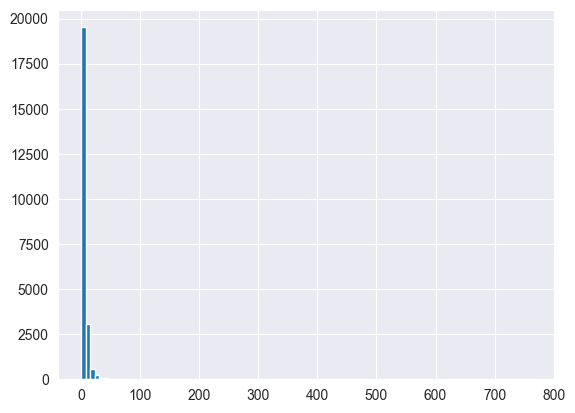

In [26]:
# Проверка высшей границы цен 

(data.last_price/1000000).hist(bins=100);

Изучая гистограмму цен, можно также заметить, что предложений с ценой выше 50 млн. так мало, что они не отображаются на графике, в связи с чем было принято решение удалить все эти строки.

In [27]:
data = data.loc[(data.last_price <= 50000000)]

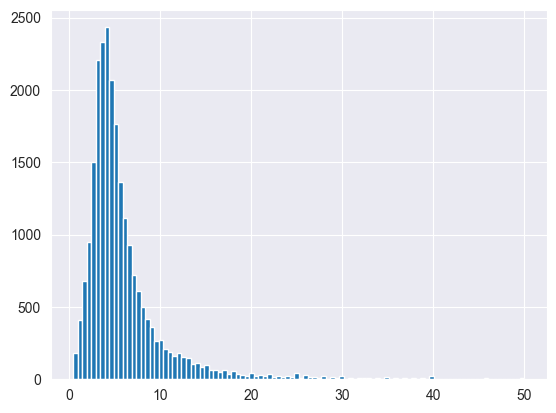

In [28]:
(data.last_price/1000000).hist(bins=100);

Теперь график выглядит намного лучше.

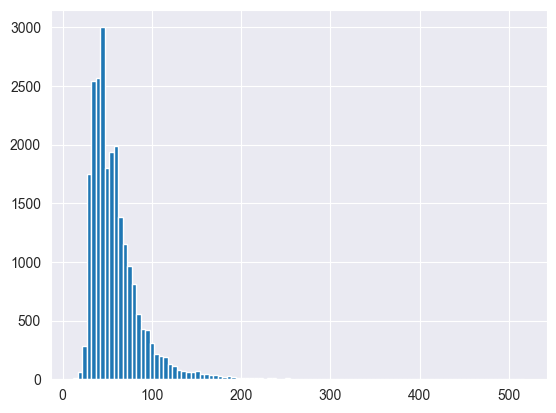

In [29]:
# Проверка высшей границы общей площади

(data.total_area).hist(bins=100);

По графику видно, что строки со значением площади выше 250 кв. м попадаются очень редко, так что удалим их. 

In [30]:
data = data.loc[(data.total_area <= 250)]

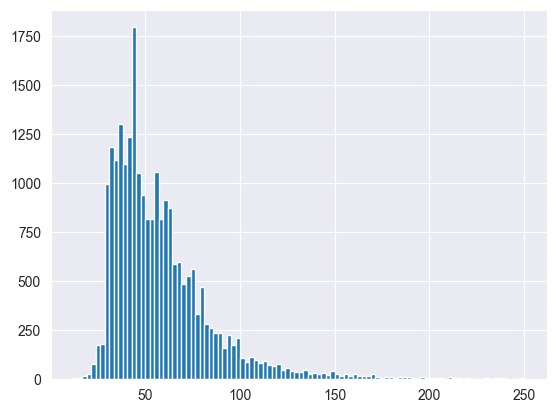

In [31]:
(data.total_area).hist(bins=100);

Как показывает график, данные успешно удалены

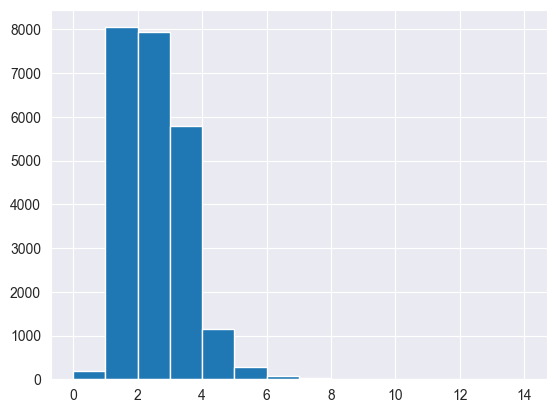

In [32]:
# Проверка высшей границы количества комнат

(data.rooms).hist(bins=data['rooms'].max());

Значения выше 8 не видно на графике, удалим их.

In [33]:
data = data.loc[(data.rooms <= 8)]

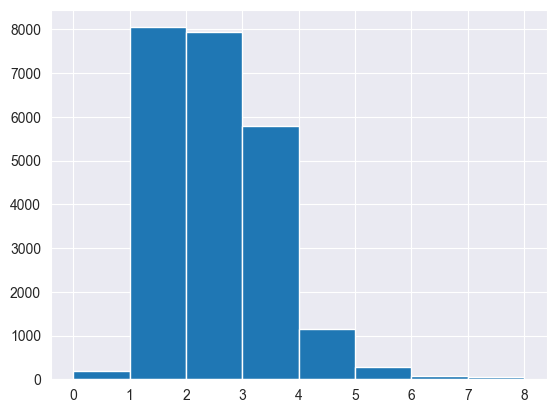

In [34]:
(data.rooms).hist(bins=data['rooms'].max());

Строки успешно удалены.

In [35]:
# Расчёт потери данных

print(data.shape[0] / old_data.shape[0])

0.991729608844255


Потери составляют чуть меньше 1% от датафрейма, так что можно продолжить работу с данными.

### Добавление в таблицу новых столбцов

In [36]:
# цена одного квадратного метра
data['sq_meter_price'] = data['last_price'] / data['total_area']

# день недели публикации объявления (0 — понедельник, 1 — вторник и так далее)
data['weekday_exposition'] = data['first_day_exposition'].dt.dayofweek

# месяц публикации объявления
data['month_exposition'] = data['first_day_exposition'].dt.month

# год публикации объявления
data['year_exposition'] = data['first_day_exposition'].dt.year

# тип этажа квартиры
data.loc[data.floor == 1, 'floor_type'] = 'первый'
data.loc[data.floor == data.floors_total, 'floor_type'] = 'последний'
data.loc[~data.floor_type.isin(['первый', 'последний']), 'floor_type'] = 'другой'

# округленное расстояние до центра города в километрах
data['city_centr_nearest_km'] = data['cityCenters_nearest'].div(1000).round(0)

data[['sq_meter_price', 'weekday_exposition', 'month_exposition', 'year_exposition', 'floor_type', 'city_centr_nearest_km']]

,sq_meter_price,weekday_exposition,month_exposition,year_exposition,floor_type,city_centr_nearest_km
0,120370.370370,3,3,2019,другой,16.0
1,82920.792079,1,12,2018,первый,19.0
2,92785.714286,3,8,2015,другой,14.0
4,100000.000000,1,6,2018,другой,8.0
5,95065.789474,0,9,2018,другой,NaN
...,...,...,...,...,...,...
23694,72490.845228,1,3,2017,другой,4.0
23695,52542.372881,0,1,2018,другой,NaN
23696,44091.710758,6,2,2018,первый,NaN
23697,149511.400651,1,3,2017,другой,10.0


### Исследовательский анализ данных

#### Изучение параметров недвижимости и построение гистограмм

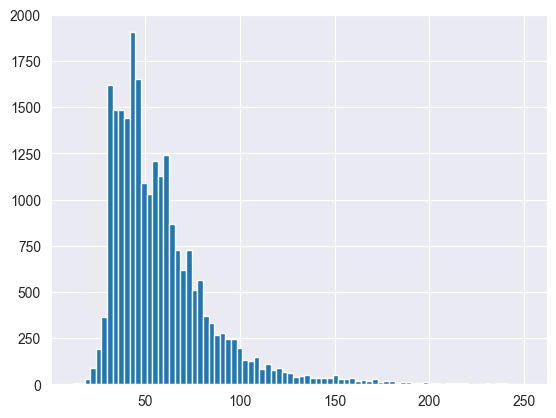

count    23503.000000
mean        58.540478
std         27.851731
min         12.000000
25%         40.000000
50%         52.000000
75%         69.000000
max        250.000000
Name: total_area, dtype: float64

In [37]:
# Общая площадь

data.total_area.hist(bins=80);
plt.show()
data.total_area.describe()

Общая площадь резко возрастает в начале графика, после чуть менее резко падает. Связано это, скорее всего, с тем, что самые частые варианты квартир имеют площадь от 30 до 60 квадратных метров. Однокомнатные квартиры и студии с маленькой площадью не так давно находятся на рынке недвижимости, из-за чего и наблюдается малое количество предложений. "Элитарное" жильё с большой площадью также не распространено, связано это со стоимостью и с редкостью такого жилья.

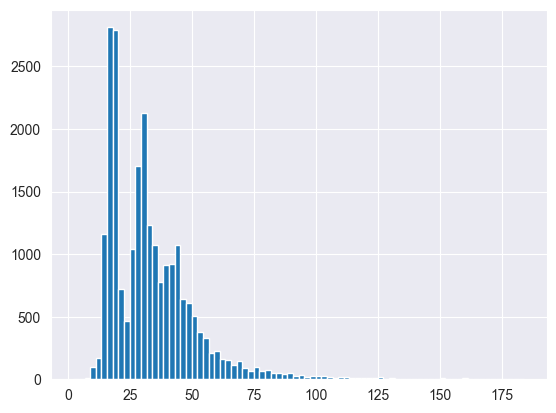

count    23503.000000
mean        33.560109
std         18.214493
min          2.000000
25%         19.000000
50%         30.000000
75%         42.000000
max        184.000000
Name: living_area, dtype: float64

In [38]:
# Жилая площадь

data.living_area.hist(bins=80);
plt.show()
data.living_area.describe()

Аналогично для жилой площади, за исключением аномального скачка графика вниз в середине графика.

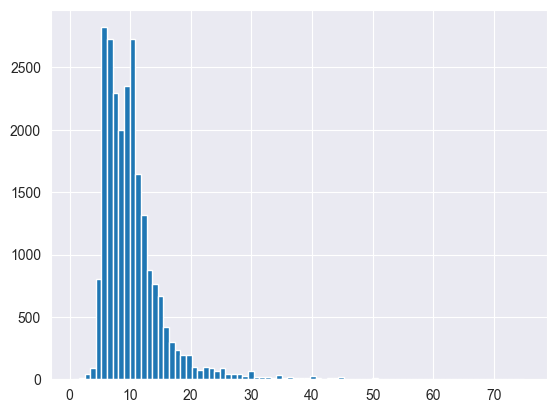

count    23503.000000
mean        10.318321
std          5.309647
min          0.611076
25%          7.000000
50%          9.000000
75%         11.900000
max         75.000000
Name: kitchen_area, dtype: float64

In [39]:
# Площадь кухни

data.kitchen_area.hist(bins=80);
plt.show()
data.kitchen_area.describe()

Значения на этом графике распределяются аналогично графику общей площади.

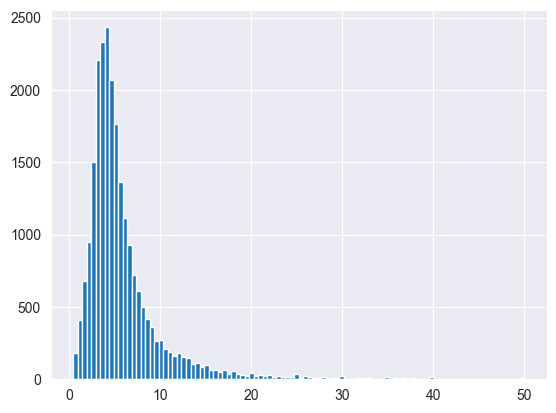

count    23503.000000
mean         5.934459
std          4.798941
min          0.430000
25%          3.400000
50%          4.600000
75%          6.700000
max         50.000000
Name: last_price, dtype: float64

In [40]:
# Цена объекта

(data.last_price/1000000).hist(bins=100);
plt.show()
((data.last_price)/1000000).describe()

Если графики предыдущих параметров были больше похожи на распределение Пуассона, то этот график приобретает вид нормального распределения: постепенное повышение цен, после постепенное снижение.

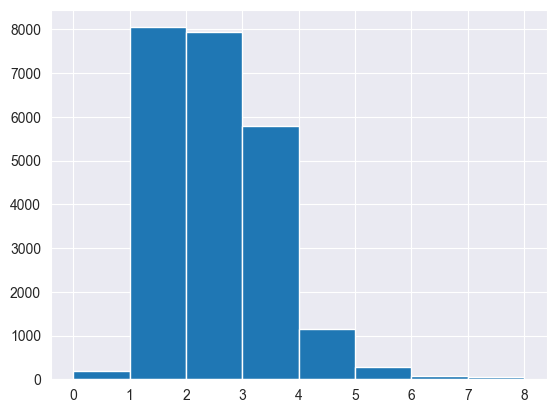

count    23503.000000
mean         2.043271
std          1.012915
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          8.000000
Name: rooms, dtype: float64

In [41]:
# Количество комнат

data.rooms.hist(bins=data['rooms'].max());
plt.show()

data.rooms.describe()

По графику видно, что самые "ходовые" квартиры на рынке это "двушки" и "однушки", "трёшки" замыкают топ-3. С графиком не поспоришь, так как большинству семей с головой хватает 3 комнат.

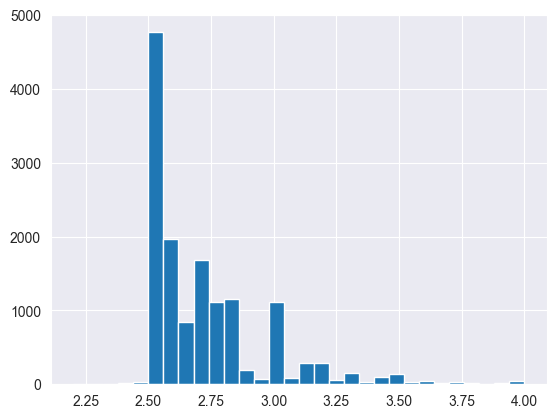

count    14319.000000
mean         2.716929
std          0.251765
min          2.200000
25%          2.500000
50%          2.650000
75%          2.800000
max          4.000000
Name: ceiling_height, dtype: float64

In [42]:
# Высота потолков

data.ceiling_height.hist(bins=30);
plt.show()
data.ceiling_height.describe()


Виднеется пик на 2.65 метра, так как это самая распространенная высота потолков.

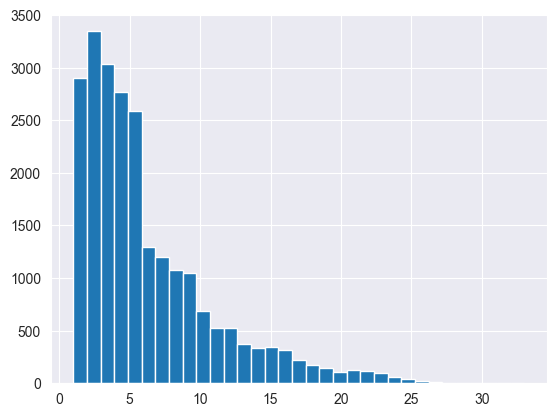

count    23503.000000
mean         5.898056
std          4.892695
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

In [43]:
# Этаж

data.floor.hist(bins=33);
plt.show()
data.floor.describe()

Виднеется распределение Пуассона. Это логично, так как не все города могут позволить себе слишком высокие здания. Также львиную долю многоквартирных домов составляют советские "хрущёвки", из-за чего проявляется такое количество этажей.

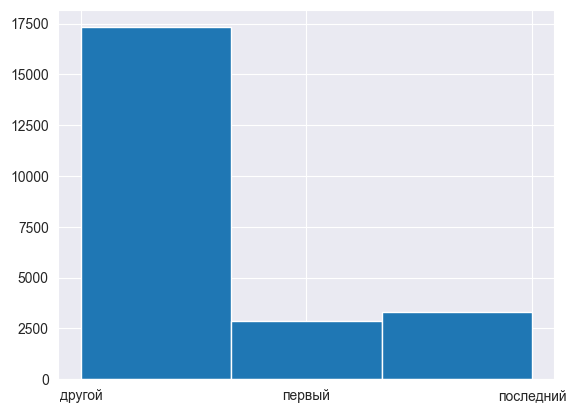

In [44]:
# Тип этажа квартиры

data.floor_type.hist(bins=3)
plt.show()


Как и ожидалось, квартир, находящихся между первым и последним этажами, большинство.

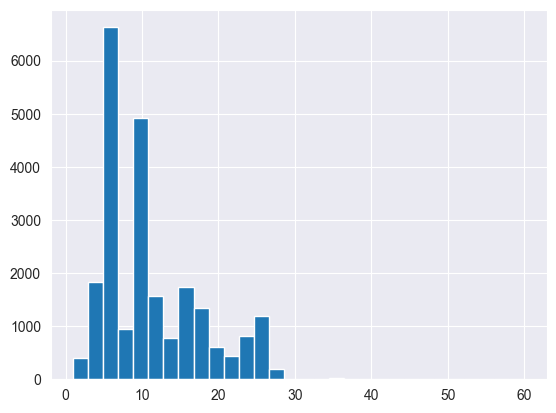

count      23418.0
mean     10.704501
std       6.606165
min            1.0
25%            5.0
50%            9.0
75%           16.0
max           60.0
Name: floors_total, dtype: Float64

In [45]:
# Общее количество этажей в доме

data.floors_total.hist(bins=30);
plt.show()
data.floors_total.describe()

По графику можно понять, что самыми популярными жилыми зданиями остаются пяти- и девятиэтажки.

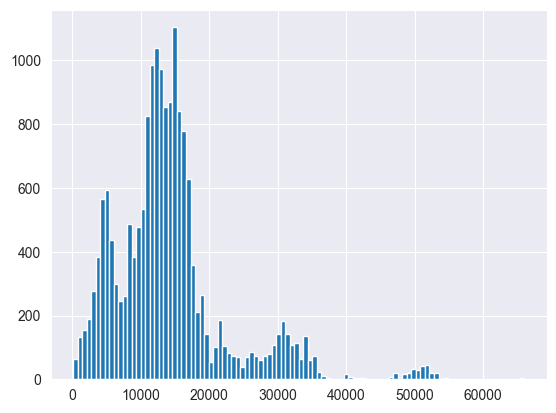

count    17987.000000
mean     14279.815200
std       8596.426482
min        181.000000
25%       9424.000000
50%      13149.000000
75%      16333.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

In [46]:
# Расстояние до центра города в метрах

data.cityCenters_nearest.hist(bins=100);
plt.show()
data.cityCenters_nearest.describe()

Чаще всего встречаются объекты недвижимости на расстоянии в 20 километров от центра города, после этой черты идёт резкий спад.

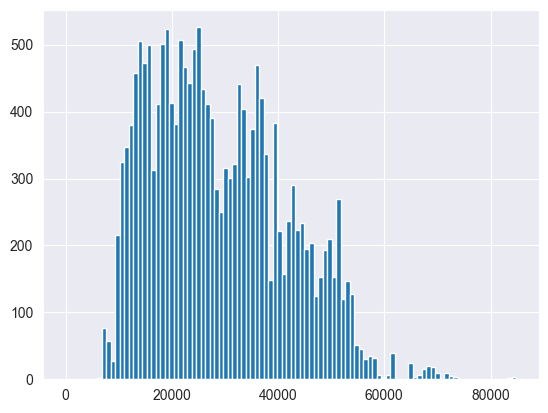

count    17966.000000
mean     28816.080263
std      12677.494126
min          0.000000
25%      18522.000000
50%      26769.000000
75%      37360.750000
max      84869.000000
Name: airports_nearest, dtype: float64

In [47]:
# Расстояние до ближайшего аэропорта в метрах

data.airports_nearest.hist(bins=100);
plt.show()
data.airports_nearest.describe()

На графике наблюдается снижение, но не резкое.

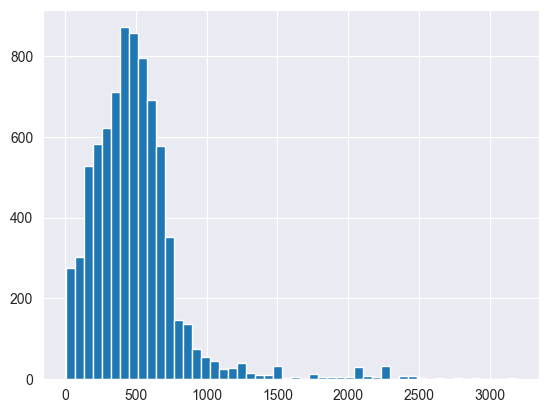

count    7940.000000
mean      492.325315
std       342.415050
min         1.000000
25%       288.000000
50%       456.000000
75%       613.000000
max      3190.000000
Name: parks_nearest, dtype: float64

In [48]:
# Расстояние до ближайшего парка в метрах

data.parks_nearest.hist(bins=50);
plt.show()
data.parks_nearest.describe()

До расстояния в 1 км наблюдается нормальное распределение значений, после чего количество объектов падает и остаётся на низком уровне.

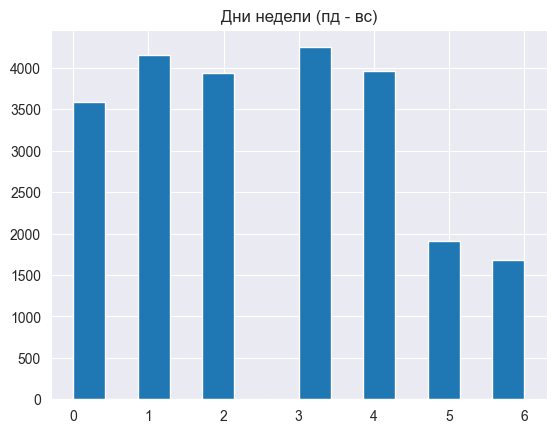

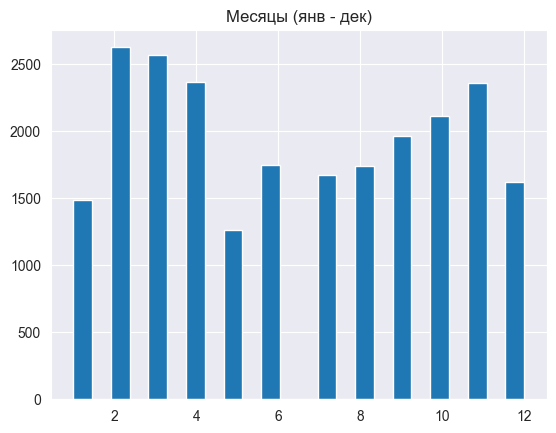

In [49]:
# День и месяц публикации

data.weekday_exposition.hist(bins=14);
plt.title("Дни недели (пд - вс)")
plt.show()
data.month_exposition.hist(bins=24);
plt.title("Месяцы (янв - дек)")
plt.show()

Активнее всего люди публикуют в будние дни. А если говорить в отношении месяцев, то чаще всего публикации появляются весной.

#### Как быстро продаются квартиры?

 Максимальная длительность продажи квартиры 1580 сут.
 Минимальная длительность продажи квартиры 1 сут.


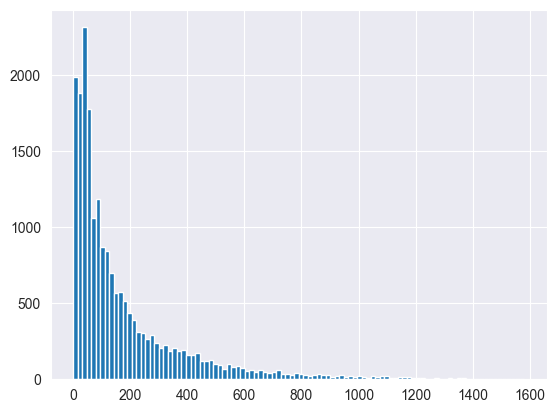

count       20364.0
mean     179.923492
std      218.793218
min             1.0
25%            45.0
50%            95.0
75%           230.0
max          1580.0
Name: days_exposition, dtype: Float64

In [50]:
# Как быстро продаются квартиры

print(f' Максимальная длительность продажи квартиры {data.days_exposition.max()} сут.')
print(f' Минимальная длительность продажи квартиры {data.days_exposition.min()} сут.')

data.days_exposition.hist(bins=100);
plt.show()
data.days_exposition.describe()

Судя по значениям, полученным путём использования метода `describe()`, можно понять, что стандартное время продажи – 95 дней. Быстрыми продажами можно назвать продажи сделанные менее, чем за 45 дней, а долгими – больше, чем за 232 дня.

#### Зависимость цен от других характеристик

0.7746228981050762

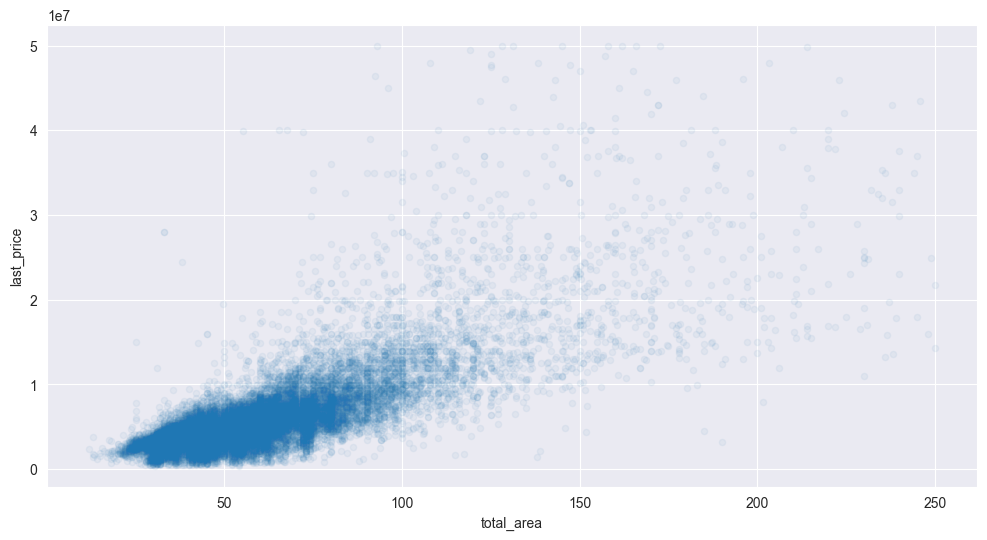

In [51]:
# Общая площадь

data.plot(y='last_price', x='total_area', kind='scatter', alpha=0.05, figsize=(12, 6))
data['last_price'].corr(data['total_area'])

Проявляется средняя положительная корреляция, оно и понятно, чем больше квартира, тем она будет дороже.

0.676608577380766

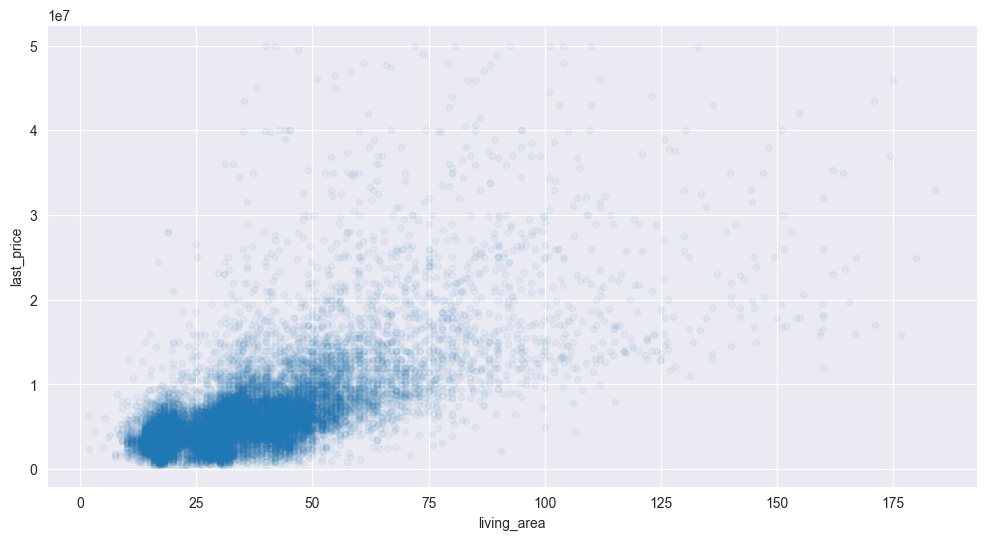

In [52]:
# Жилая площадь

data.plot(y='last_price', x='living_area', kind='scatter', alpha=0.05, figsize=(12, 6))
data['last_price'].corr(data['living_area'])

Аналогично, за исключением того, что корреляция здесь чуть слабее.

0.6129559179307059

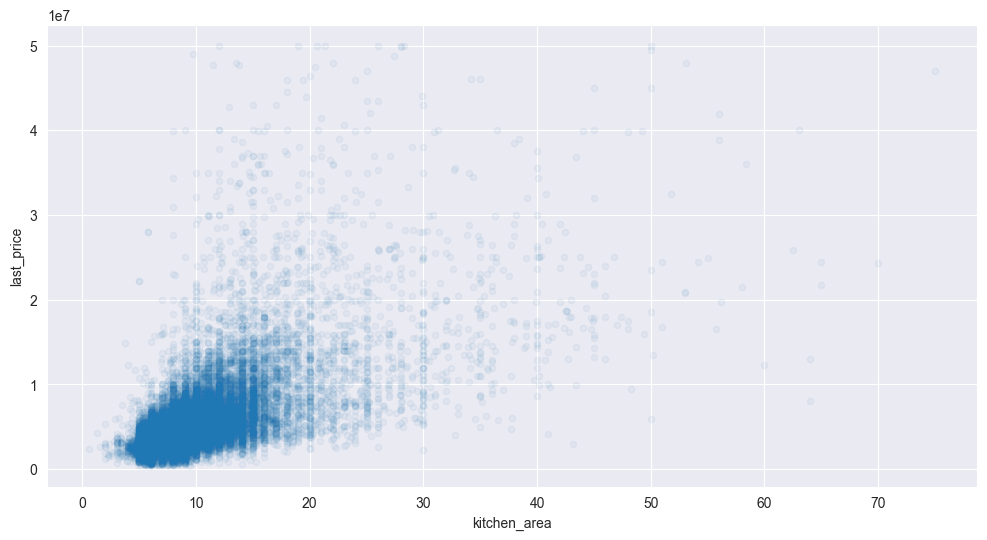

In [53]:
# Площадь кухни

data.plot(y='last_price', x='kitchen_area', kind='scatter', alpha=0.05, figsize=(12, 6))
data['last_price'].corr(data['kitchen_area'])

Аналогично

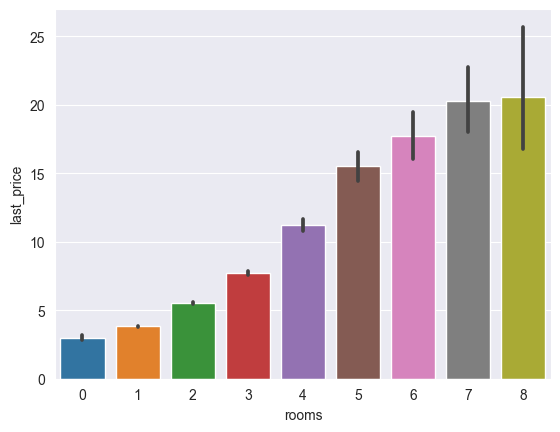

0.48765298520646616

In [54]:
# Количество комнат
sb.barplot(data=data, y=(data.last_price)/1000000, x ='rooms');
plt.show()
data['last_price'].corr(data['rooms'])

Здесь же корреляция уже ниже средней. Объясняется это тем, что не всегда квартиры с малым количеством комнат маленькие в площади, и наоборот.

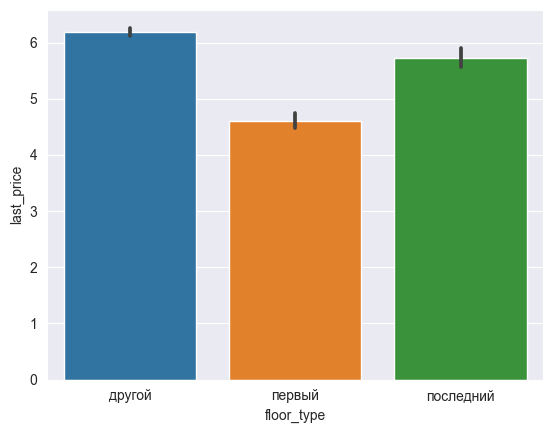

In [55]:
# День недели
sb.barplot(data=data, y=(data.last_price)/1000000, x ='floor_type');
plt.show()

Видно, что средняя цена объявлений с первым этажом меньше, объясняется это тем, что на первых этажах чаще всего менее комфортные условия для жизни (к примеру, шум с улицы или проблемы с канализацией).

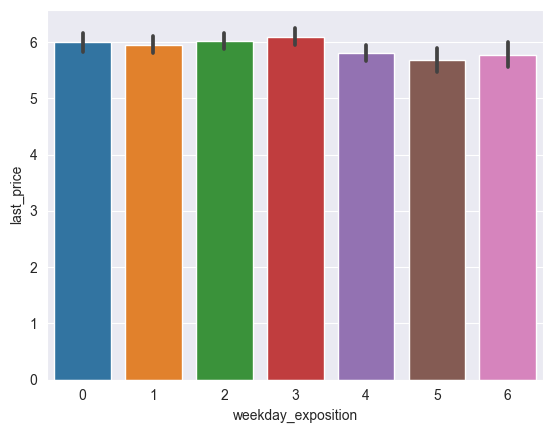

In [56]:
# День недели
sb.barplot(data=data, y=(data.last_price)/1000000, x ='weekday_exposition');

Корреляции не наблюдается, значения средней цены остаются на одном уровне.

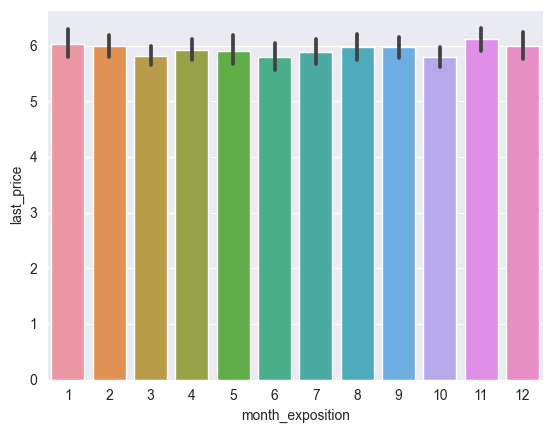

In [57]:
# Месяц
sb.barplot(data=data, y=(data.last_price)/1000000, x ='month_exposition');

Аналогично

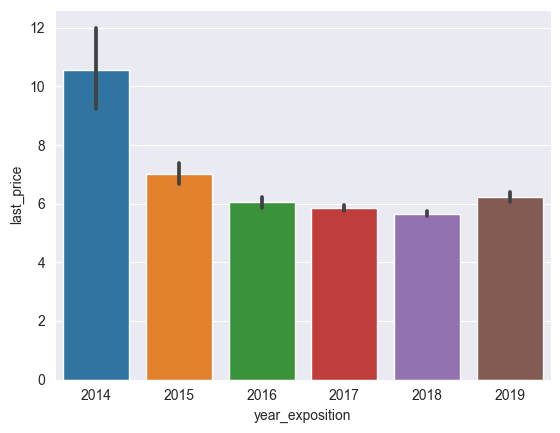

In [58]:
# Год
sb.barplot(data=data, y=(data.last_price)/1000000, x ='year_exposition');

А вот год влияет на среднюю цену. Можно заметить, что средняя цена на квартиры постоянно снижалась, за исключением последнего года. Это можно объяснить обвалом рубля 2014 года и его последующим постепенным усилением.

#### Вычисление средней цены одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

In [59]:
mean_sq_meter_price_table = pd.pivot_table(data, 
                                           index='locality_name', 
                                           values='sq_meter_price', 
                                           aggfunc=['mean', 'count'])

mean_sq_meter_price_table_sorted = mean_sq_meter_price_table.sort_values([('count', 'sq_meter_price')], ascending=False).head(10)
mean_sq_meter_price_table_sorted.columns = ['Средняя цена за квадратный метр', 'Количество объявлений']
mean_sq_meter_price_table_sorted.index.name = 'Населённый пункт'
mean_sq_meter_price_table_sorted

,Средняя цена за квадратный метр,Количество объявлений
Населённый пункт,,
Санкт-Петербург,112301.284405,15529
посёлок Мурино,85681.762601,556
посёлок Шушары,78677.364217,440
Всеволожск,68654.473986,398
Пушкин,103130.851744,367
Колпино,75333.295801,337
посёлок Парголово,90175.913458,327
Гатчина,68746.146763,307
деревня Кудрово,92473.547576,299


In [60]:
print(f'Самая высокая средняя цена квадратного метра наблюдается в {mean_sq_meter_price_table_sorted["Средняя цена за квадратный метр"].idxmax()}е и составляет {mean_sq_meter_price_table_sorted["Средняя цена за квадратный метр"][mean_sq_meter_price_table_sorted["Средняя цена за квадратный метр"].idxmax()]: .2f} руб.')

print(f'Самая низкая средняя цена квадратного метра наблюдается в {mean_sq_meter_price_table_sorted["Средняя цена за квадратный метр"].idxmin()}е и составляет {mean_sq_meter_price_table_sorted["Средняя цена за квадратный метр"][mean_sq_meter_price_table_sorted["Средняя цена за квадратный метр"].idxmin()]: .2f} руб.')

Самая высокая средняя цена квадратного метра наблюдается в Санкт-Петербурге и составляет  112301.28 руб.
Самая низкая средняя цена квадратного метра наблюдается в Выборге и составляет  58141.91 руб.


#### Вычисление средней цены каждого километра расстояния до центра в Санкт-Петербурге

,last_price
city_centr_nearest_km,
0.00,20577462.09
1.00,12599074.71
2.00,12127815.97
3.00,10124863.60
4.00,10995491.72
5.00,11542679.37
6.00,11736243.22
7.00,11381395.04
8.00,9031684.03


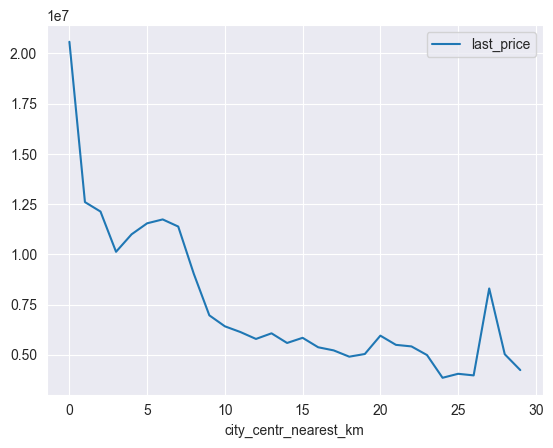

,city_centr_nearest_km,last_price
city_centr_nearest_km,1.00,-0.79
last_price,-0.79,1.00


In [61]:
pd.options.display.float_format = '{:.2f}'.format
city_centr_near_table = pd.pivot_table(data[data['locality_name'] == 'Санкт-Петербург'], index='city_centr_nearest_km', values='last_price', aggfunc='mean')
display(city_centr_near_table)
city_centr_near_table.reset_index().plot(y='last_price', x='city_centr_nearest_km')
plt.show()
city_centr_near_table.reset_index().corr()

На таблицах и графике видно, что стоимость жилья увеличивается ближе к центру и уменьшается, отдалясь от него. Это логично, так как именно в центре находится больше всего мест для отдыха, развлечений, возможно мест работы.   
Исходя из графика, можно предположить, что радиус прицентровой (а значит и дорогого жилья) территории равняется 7 км, так как после этой отметки цены сильно понижаются.

### Общий вывод

В самом начале работы было замечено, что некоторые данные являются аномалиями, имеют неправильный тип данных или же вовсе отсутствуют.  
На этапе обработки были устранены все аномалии и неточности, были заполнены пропуски (там, где это возможно). Всё это было сделано для того, чтобы результаты исследования оказались более объективными.
Были построены и проанализированы отдельные гистограммы для большинства параметров, среди которых были и новые столбцы, полученные путём различных вычислений.  
Изучены факторы, влияющие на стоимость объекта, после чего были построены гистограммы.

На базе полученных данных можно сделать некоторые выводы:  

        - основу всех предложений составляют квартиры площадью от 30 до 60 квадратных метров;
        - самые "ходовые" квартиры на рынке это "двушки" и "однушки", "трёшки" замыкают топ-3;
        - самая распространенная высота потолков - 2.65 метра;
        - самыми популярными жилыми зданиями остаются пяти- и девятиэтажки;
        - бóльшая часть объявлений затрагивает территорию в 20 километров от центра города, за этой чертой предложений значительно меньше
        - активнее всего люди публикуют объявления в будние дни, самым же активным сезоном является весна.

Также были произведены расчёты по вычислению средней цены одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений, в результате которых, мы узнали, что:  

        самая высокая средняя цена квадратного метра наблюдается в Санкт-Петербурге и составляет 114856.31 рублей;
        самая низкая средняя цена квадратного метра наблюдается в Выборге и составляет 58141.91 рубль.

На основе проделанной работы можно выделить некоторые зависимости ценообразования в этом срезе данных:  

        - цена средне увеличивается при увеличении общей площади (коэффициент корреляции 0.65);
        - цена средне увеличивается при увеличении жилой площади (коэффициент корреляции 0.57);
        - цена средне увеличивается при увеличении площади кухни (коэффициент корреляции 0.52);
        - цена сильно увеличивается при уменьшении расстояния от центра города (коэффициент корреляции -0.76);
        - квартиры на первых этажах в среднем дешевле остальных;
        - средняя цена на квартиры заметно падала, начиная с 2014 года и заканчивая 2018-ым.

Такая большая отрицательная корреляция цены и расстояния от центра города легко объяснима. Большая часть объявлений затрагивает город Санкт-Петербург, культурную столицу России. Из всей этой базы объявлений стало ясно, что люди дороже оценивают близость к Невскому проспекту, чем качество самих квартир.